In [16]:
import sys
import torch
import os 
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from PIL import Image
sys.path.append('..')  
import scipy
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from torchvision import models, transforms
from types import SimpleNamespace
from model.model import MMC  
from src.config import Config
import pickle
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"


In [2]:
args = SimpleNamespace(
    name='MMC',
    dataset='n24news',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=32,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='roberta_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')

../datasets/


In [3]:
model = MMC(args)
softclip_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/n24news-best-softclip.pth'
model.load_state_dict(torch.load(softclip_model_path))
model_soft_clip_only = model.to(device=args.device)

In [4]:
model = MMC(args)
multimixco_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/n24news-best-m3col.pth'
model.load_state_dict(torch.load(multimixco_model_path))
model_m3co_only = model.to(device=args.device)

In [5]:
model = MMC(args)
multimixco_softclip_model_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/Path/To/results/models/n24news-best-m3col-softclip.pth'
model.load_state_dict(torch.load(multimixco_softclip_model_path))
model_both = model.to(device=args.device)

In [6]:
def get_sentence_embedding(text, model, args):
    # Assuming the model's text_encoder has already been initialized
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)

    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            token_type_ids = encoded_input.get('token_type_ids').to(device=args.device)
            embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    embeddings = embeddings.squeeze(dim = 0)
    final_embedding = embeddings[0, :]
    final_embedding = final_embedding / final_embedding.norm()

    return final_embedding

In [7]:
def get_image_embedding(image_path, model, args):
    image = Image.open(image_path).convert('RGB')
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  
    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    image_embeddings = image_embeddings.squeeze()
    # Taking final embedding as cls embedding
    final_embedding = image_embeddings[0,:]
    final_embedding = final_embedding / final_embedding.norm()
    
    return final_embedding

In [8]:
def get_combined_embedding(image, text, model, args):
    
    feature_extractor = model.image_encoder.get_tokenizer()  # Ensure this method is properly returning the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']

    model.eval()
    pixel_values = pixel_values.to(args.device)  
    # Extract embeddings
    with torch.no_grad():
        image_embeddings = model.image_encoder(pixel_values)
    
    image_embeddings = image_embeddings.squeeze()
    # Taking final embedding as cls embedding
    final_embedding_image = image_embeddings[0,:]
    final_embedding_image = final_embedding_image / final_embedding_image.norm()
    
    tokenizer = model.text_encoder.get_tokenizer()
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input['input_ids'].to(device=args.device)
    attention_mask = encoded_input['attention_mask'].to(device=args.device)

    with torch.no_grad():
        if 'roberta' in model.text_encoder.text_encoder:
            text_embeddings = model.text_encoder.forward((input_ids, None, attention_mask))
        else:
            token_type_ids = encoded_input.get('token_type_ids').to(device=args.device)
            text_embeddings = model.text_encoder.forward((input_ids, token_type_ids, attention_mask))

    text_embeddings = text_embeddings.squeeze(dim = 0)
    final_embedding_text = text_embeddings[0, :]
    final_embedding_text = final_embedding_text / final_embedding_text.norm()

    final_fused_combined = torch.cat([final_embedding_text, final_embedding_image], dim=-1)
        #final_fused_combined = final_fused_combined / final_fused_combined.norm(dim=-1, keepdim=True)
    return final_embedding_image, final_embedding_text, final_fused_combined

In [9]:
def get_image_paths(folder_path, extension="jpg"):
    return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(extension)]

def get_text_paths(folder_path, extension="txt"):
    return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(extension)]

# def visualize_embeddings(type_title, embeddings, labels, method="tsne", n_components=2, perplexity=30, n_neighbors=15, min_dist=0.1):
#     if method == "tsne":
#         reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
#     elif method == "umap":
#         reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
#     else:
#         raise ValueError("Method should be either 'tsne' or 'umap'")
    
#     reduced_embeddings = reducer.fit_transform(embeddings)
#     unique_labels = np.unique(labels)
#     colors = plt.cm.get_cmap('tab10', len(unique_labels))

#     for i, label in enumerate(unique_labels):
#         indices = labels == label
#         plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], s=10, cmap=colors(i), label=f"Class {label}")
    
#     #plt.title(f"{method.upper()} Visualization of Image Embeddings")
#     title_string = "Visualization of " + type_title + ' Embeddings'
#     plt.title(title_string)
#     plt.legend()
#     plt.show()



def visualize_embeddings(type_title, embeddings, labels, method="umap", n_components=2, perplexity=30, n_neighbors=15, min_dist=0.1):
    if method == "umap":
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    for i, label in enumerate(unique_labels):
        indices = labels == label
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], s=10, cmap=colors(i), label=f"Class {label}")
    
    #plt.title(f"{method.upper()} Visualization of Image Embeddings")
    title_string = "Visualization of " + type_title + ' Embeddings'
    plt.title(title_string)
    plt.show()

In [18]:
def save_embeddings(model, model_name, args):
    folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'
    folder_path_text_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'
    save_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks'

    subfolders = [f.name for f in os.scandir(folder_path_images_test) if f.is_dir()]
    class_to_label = {class_name: i for i, class_name in enumerate(subfolders)}
    label_to_class = {i:class_name for class_name,i in class_to_label.items() }

    test_image_embeddings = {}
    test_text_emebddings = {}
    test_combined_embeddings = {}
    order_of_ids = {}

    for class_name in subfolders:
        test_image_embeddings[class_name] = [] 
        test_text_emebddings[class_name] = []
        test_combined_embeddings[class_name] = []
        order_of_ids[class_name] = []
        
        image_dir_patch = os.path.join(folder_path_images_test, class_name)
        text_dir_path = os.path.join(folder_path_text_test, class_name)
        image_names = [f.name for f in os.scandir(image_dir_patch)]
        image_ids = [image_name[:-4] for image_name in image_names]

        for image_id in tqdm(image_ids):
            
            image_path = image_dir_patch + '/' + image_id + '.jpg' 
            text_path = text_dir_path + '/' + image_id + '.txt'
            image = Image.open(image_path).convert('RGB')
            with open(text_path, 'r') as f:
                text = f.read()
            
            final_embedding_image, final_embedding_text, final_fused_combined = get_combined_embedding(image, text, model, args)
            order_of_ids[class_name].append(image_id)
            test_image_embeddings[class_name].append(final_embedding_image.cpu().numpy())
            test_text_emebddings[class_name].append(final_embedding_text.cpu().numpy())
            test_combined_embeddings[class_name].append(final_fused_combined.cpu().numpy())
    
    
    with open(os.path.join(save_path, 'test_image_embeddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_image_embeddings, f)
    with open(os.path.join(save_path, 'test_text_emebddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_text_emebddings, f)
    with open(os.path.join(save_path, 'test_combined_embeddings_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(test_combined_embeddings, f)
    with open(os.path.join(save_path, 'order_of_ids_' + model_name + '.pkl'), 'wb') as f:
        pickle.dump(order_of_ids, f)

In [72]:
save_embeddings(model_soft_clip_only,'soft_clip_only',args)

100%|██████████| 311/311 [00:12<00:00, 24.86it/s]


In [73]:
save_embeddings(model_m3co_only,'m3co_only',args)

100%|██████████| 311/311 [00:12<00:00, 24.34it/s]


In [74]:
save_embeddings(model_both,'both',args)

100%|██████████| 311/311 [00:12<00:00, 25.90it/s]


In [10]:
folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'
subfolders = [f.name for f in os.scandir(folder_path_images_test) if f.is_dir()]
class_to_label = {class_name: i for i, class_name in enumerate(subfolders)}
label_to_class = {i:class_name for class_name,i in class_to_label.items() }

In [11]:
file_path = "/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/order_of_ids_both.pkl"
with open(os.path.join(file_path), 'rb') as f:
    order_of_ids = pickle.load(f)
count = {}
for class_name in order_of_ids.keys():
    count[len(order_of_ids[class_name])] = class_name

print(count) 
count_sorted = (sorted(count, reverse=True))
classes_to_be_considered = []
for c in count_sorted[0:10]:
    print(count[c])
    classes_to_be_considered.append(count[c])
print(classes_to_be_considered)

{263: 'Style', 290: 'Food', 100: 'Global Business', 299: 'Real Estate', 80: 'Well', 134: 'Your Money', 287: 'Travel', 74: 'Education', 173: 'Automobiles', 306: 'Science', 313: 'Art & Design', 307: 'Fashion & Style', 326: 'Media', 281: 'Television', 292: 'Movies', 183: 'Economy', 280: 'Sports', 325: 'Technology', 286: 'Music', 318: 'Dance', 305: 'Books', 284: 'Opinion', 311: 'Theater'}
Media
Technology
Dance
Art & Design
Theater
Fashion & Style
Science
Books
Real Estate
Movies
['Media', 'Technology', 'Dance', 'Art & Design', 'Theater', 'Fashion & Style', 'Science', 'Books', 'Real Estate', 'Movies']


In [12]:
def get_figures(base_path, model_name, classes_to_be_considered, class_to_label, type):
    file_path = base_path + model_name + '.pkl'
    with open(os.path.join(file_path), 'rb') as f:
        embeddings_saved = pickle.load(f)
    
    embeddings = []
    labels = []
    for class_name in embeddings_saved.keys():
        if class_name in classes_to_be_considered:
            label = class_to_label[class_name]
            embeddings = embeddings + embeddings_saved[class_name]
            label_list = [label]*len(embeddings_saved[class_name])
            labels = labels + label_list 

    labels = np.array(labels)
    print("MODEL NAME: ") 
    print(model_name)
    visualize_embeddings(type, embeddings, labels, method="umap")
    silh_score = silhouette_score(embeddings, labels)
    db_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)
    print(f"Davies-Bouldin Score: {db_score}")
    print(f"Calinski-Harabasz Score: {ch_score}")
    print(f"Silhouette Score: {silh_score}")

In [48]:
def get_figures_2(base_path, model_name, classes_to_be_considered, class_to_label, type):
    file_path = base_path + model_name + '.pkl'
    with open(os.path.join(file_path), 'rb') as f:
        embeddings_saved = pickle.load(f)
    
    embeddings = []
    labels = []
    for class_name in embeddings_saved.keys():
        if class_name in classes_to_be_considered:
            label = class_to_label[class_name]
            embeddings = embeddings + embeddings_saved[class_name]
            label_list = [label]*len(embeddings_saved[class_name])
            labels = labels + label_list 

    labels = np.array(labels)
    print("MODEL NAME: ") 
    print(model_name)

    if len(embeddings) != len(labels):
        raise ValueError("The number of embeddings must match the number of labels")

    # Setting UMAP parameters
    n_neighbors = 15
    n_components = 2
    min_dist_value = 0.01  # Example: A smaller distance
    spread_value = 3    # Default value

    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, 
                        metric='euclidean', min_dist=min_dist_value, spread=spread_value)
    embedding = reducer.fit_transform(embeddings)  # Reduce dimensionality

    # Create a DataFrame for easier plotting
    umap_df = pd.DataFrame(embedding, columns=['UMAP dimension 1', 'UMAP dimension 2'])
    umap_df['label'] = labels

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='label', data=umap_df, palette=sns.color_palette("bright", len(pd.unique(umap_df['label']))), legend= False)
    t = 'UMAP projection of the dataset for ' + type + ' embeddings' 
    plt.title(t)
    #plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
    plt.show()
        
    # visualize_embeddings(type, embeddings, labels, method="umap")
    # silh_score = silhouette_score(embeddings, labels)
    # db_score = davies_bouldin_score(embeddings, labels)
    # ch_score = calinski_harabasz_score(embeddings, labels)
    # print(f"Davies-Bouldin Score: {db_score}")
    # print(f"Calinski-Harabasz Score: {ch_score}")
    # print(f"Silhouette Score: {silh_score}")

MODEL NAME: 
both


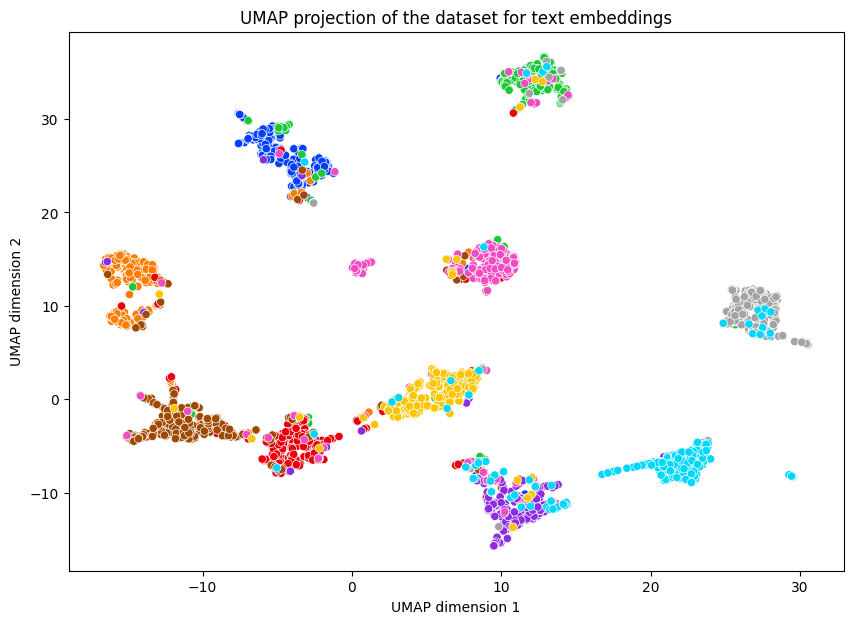

In [49]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'test_text_embeddings_'
#classes_to_be_considered = ["Art & Design", "Automobiles", "Books", "Dance", "Economy", "Education", "Fashion & Style", "Food", "Global Business", "Health"]
#classes_to_be_considered = subfolders
# model_name = "soft_clip_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'text')
# model_name = "m3co_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'text')
model_name = "both"
get_figures_2(base_path, model_name, classes_to_be_considered,class_to_label, 'text')

MODEL NAME: 
both


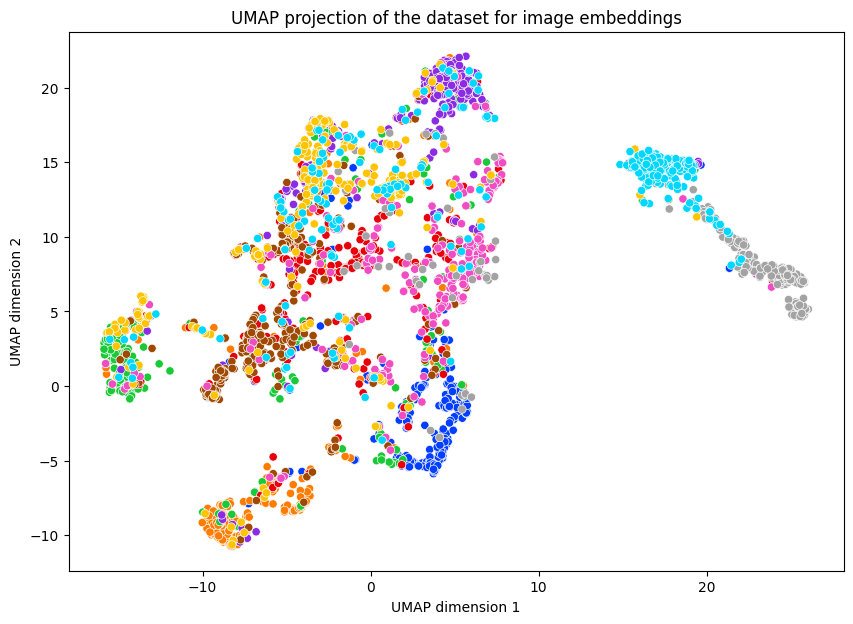

In [50]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'test_image_embeddings_'
#classes_to_be_considered = ["Art & Design", "Automobiles", "Books", "Dance", "Economy", "Education", "Fashion & Style", "Food", "Global Business", "Health"]
#classes_to_be_considered = subfolders
# model_name = "soft_clip_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'image')
# model_name = "m3co_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'image')
model_name = "both"
get_figures_2(base_path, model_name, classes_to_be_considered,class_to_label, 'image')

MODEL NAME: 
both


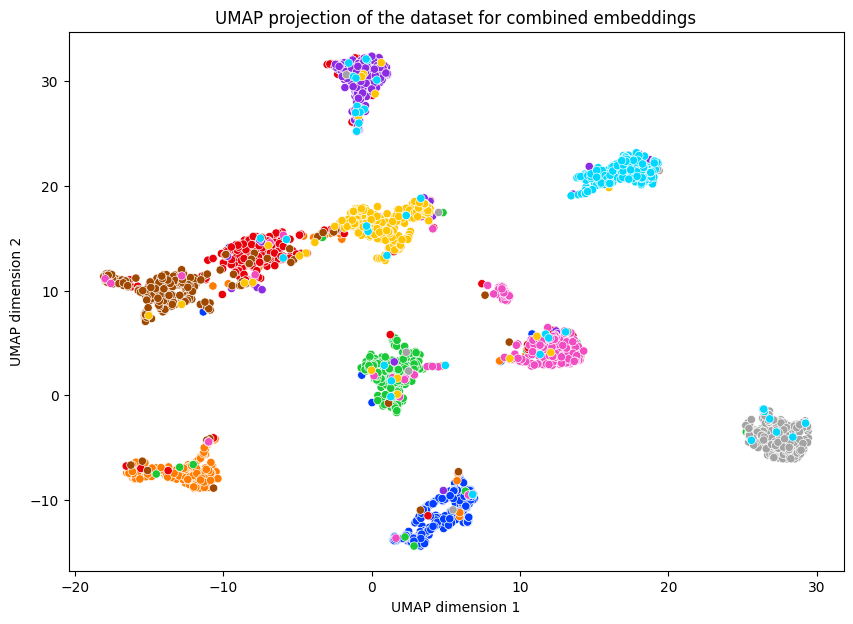

In [51]:
base_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/' + 'test_combined_embeddings_'
#classes_to_be_considered = subfolders
#classes_to_be_considered = ["Art & Design", "Automobiles", "Books", "Dance", "Economy", "Education", "Fashion & Style", "Food", "Global Business", "Health"]
# model_name = "soft_clip_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'combined')
# model_name = "m3co_only"
# get_figures(base_path, model_name, classes_to_be_considered,class_to_label, 'combined')
model_name = "both"
get_figures_2(base_path, model_name, classes_to_be_considered,class_to_label, 'combined')

In [61]:
a = [1]
b = [2,3]
a+b

[1, 2, 3]

In [ ]:

save_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks'
model_name = 'soft_clip_only' 

with open(os.path.join(save_path, 'test_image_embeddings_' + model_name + '.pkl'), 'rb') as f:
    test_image_embeddings = pickle.load(f)
with open(os.path.join(save_path, 'test_text_emebddings_' + model_name + '.pkl'), 'rb') as f:
    test_text_embeddings = pickle.load(f)
with open(os.path.join(save_path, 'test_combined_embeddings_' + model_name + '.pkl'), 'rb') as f:
    test_combined_embeddings = pickle.load(f)
with open(os.path.join(save_path, 'order_of_ids_' + model_name + '.pkl'), 'rb') as f:
    order_of_ids = pickle.load(f)

print("test_image_embeddings:", test_image_embeddings)
print("test_text_embeddings:", test_text_embeddings)
print("test_combined_embeddings:", test_combined_embeddings)
print("order_of_ids:", order_of_ids)


In [51]:
print(len(test_combined_embeddings['Style']))

1


In [16]:
folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'
subfolders_images = [f.name for f in os.scandir(folder_path_images_test) if f.is_dir()]
subfolders_images

['Style',
 'Food',
 'Global Business',
 'Real Estate',
 'Well',
 'Your Money',
 'Travel',
 'Education',
 'Automobiles',
 'Science',
 'Art & Design',
 'Health',
 'Media',
 'Television',
 'Movies',
 'Economy',
 'Sports',
 'Technology',
 'Music',
 'Fashion & Style',
 'Dance',
 'Books',
 'Opinion',
 'Theater']

In [ ]:
folder_path_images_test = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'

subfolders = [f.name for f in os.scandir(folder_path_images_test) if f.is_dir()]

image_paths_all = []
embeddings = []
labels = []

# Assign numeric labels to each class
class_to_label = {cls: i for i, cls in enumerate(subfolders)}

for i, cls in enumerate(subfolders):
    dir_patch = os.path.join(folder_path, cls)
    image_paths = get_image_paths(dir_patch)
    image_paths_all.extend(image_paths)
    print(image_paths)
    
    for img_path in tqdm(image_paths):
        # Assuming get_image_embedding function returns embeddings for an image
        embedding = get_sentence_embedding(img_path, model_multi_mixco, args)
        embedding = embedding.cpu().numpy()
        embeddings.append(embedding)
        labels.append(class_to_label[cls])

print("got all embeddings")
labels = np.array(labels)

# from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# db_score = davies_bouldin_score(embeddings, labels)
# ch_score = calinski_harabasz_score(embeddings, labels)
# print(f"Davies-Bouldin Score: {db_score}")
# print(f"Calinski-Harabasz Score: {ch_score}")
# #visualize_embeddings(embeddings, labels)

['/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/192a4cd0-b609-57f4-ae9e-2693ae31ae0e.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/8e3189c9-b6e8-5979-9ec6-3fe4c130d359.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/53e4509c-09bc-5d79-94d0-1d94056f5734.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/7b814502-930a-5366-b78f-1e8dfa2cb1c8.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/cd700791-2d63-5b14-ae69-14e0aaf87ae5.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/3a4421bc-a852-56a4-b7f7-fd4ab734a2b3.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/7963d475-a26f-5e13-91ad-97e1fcae517a.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test/Style/fc59e9fb-d066-5091-b65d-ebd9bd5ba276.jpg', '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/

  0%|          | 0/263 [00:00<?, ?it/s]

input ids shape:  torch.Size([1, 61])
attention_mask shape:  torch.Size([1, 61])


AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
  
folder_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'

subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]

image_paths_all = []
embeddings = []
labels = []

# Assign numeric labels to each class
class_to_label = {cls: i for i, cls in enumerate(subfolders)}

for i, cls in enumerate(subfolders):
    dir_patch = os.path.join(folder_path, cls)
    image_paths = get_image_paths(dir_patch)
    image_paths_all.extend(image_paths)
    
    for img_path in tqdm(image_paths):
        # Assuming get_image_embedding function returns embeddings for an image
        embedding = get_image_embedding(img_path, model_soft_clip, args)
        embedding = embedding.cpu().numpy()
        embeddings.append(embedding)
        labels.append(class_to_label[cls])

print("got all embeddings")
labels = np.array(labels)

# from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# db_score = davies_bouldin_score(embeddings, labels)
# ch_score = calinski_harabasz_score(embeddings, labels)
# print(f"Davies-Bouldin Score: {db_score}")
# print(f"Calinski-Harabasz Score: {ch_score}")
# #visualize_embeddings(embeddings, labels)

100%|██████████| 311/311 [00:16<00:00, 19.39it/s]


got all embeddings
Davies-Bouldin Score: 4.273241218581412
Calinski-Harabasz Score: 91.5247832408121


In [162]:
  
# folder_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'

# subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]

# embeddings = []
# labels = []

# # Assign numeric labels to each class
# class_to_label = {cls: i for i, cls in enumerate(subfolders)}

# for i, cls in enumerate(subfolders):
#     dir_path = os.path.join(folder_path, cls)
#     text_paths = get_text_paths(dir_path)
#     for text_path in tqdm(text_paths):
#         # Assuming get_image_embedding function returns embeddings for an image
#         # get text from text_paths
#         with open(text_path, 'r') as f:
#             text = f.read()
#         embedding = get_sentence_embedding(text, model_raja, args)
#         embedding = embedding.cpu().numpy()
#         embeddings.append(embedding)
#         labels.append(class_to_label[cls])

# print("got all embeddings")
# labels = np.array(labels)

# from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# # db_score = davies_bouldin_score(embeddings, labels)
# # ch_score = calinski_harabasz_score(embeddings, labels)
# # print(f"Davies-Bouldin Score: {db_score}")
# # print(f"Calinski-Harabasz Score: {ch_score}")
# # #visualize_embeddings(embeddings, labels)

  0%|          | 0/263 [00:00<?, ?it/s]

100%|██████████| 311/311 [00:03<00:00, 95.22it/s]


got all embeddings
Davies-Bouldin Score: 2.367138945520298
Calinski-Harabasz Score: 215.65150202804944


In [158]:
  
folder_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'

subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]

embeddings = []
labels = []

# Assign numeric labels to each class
class_to_label = {cls: i for i, cls in enumerate(subfolders)}

for i, cls in enumerate(subfolders):
    dir_path = os.path.join(folder_path, cls)
    text_paths = get_text_paths(dir_path)
    for text_path in tqdm(text_paths):
        # Assuming get_image_embedding function returns embeddings for an image
        # get text from text_paths
        with open(text_path, 'r') as f:
            text = f.read()
        embedding = get_sentence_embedding(text, model_multi_mixco, args)
        embedding = embedding.cpu().numpy()
        embeddings.append(embedding)
        labels.append(class_to_label[cls])

print("got all embeddings")
labels = np.array(labels)

# from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# db_score = davies_bouldin_score(embeddings, labels)
# ch_score = calinski_harabasz_score(embeddings, labels)
# print(f"Davies-Bouldin Score: {db_score}")
# print(f"Calinski-Harabasz Score: {ch_score}")
# #visualize_embeddings(embeddings, labels)

100%|██████████| 311/311 [00:03<00:00, 94.11it/s]


got all embeddings
Davies-Bouldin Score: 2.3656669685209253
Calinski-Harabasz Score: 223.80437002829436


100%|██████████| 307/307 [00:10<00:00, 29.71it/s]
/raid/nlp/rajak/Multimodal/UniS-MMC/multimodal/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


got all embeddings
Davies-Bouldin Score: 2.344829273290734
Calinski-Harabasz Score: 162.0647545154819


/tmp/ipykernel_219894/4077251012.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_219894/4077251012.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], s=10, cmap=colors(i), label=f"Class {label}")


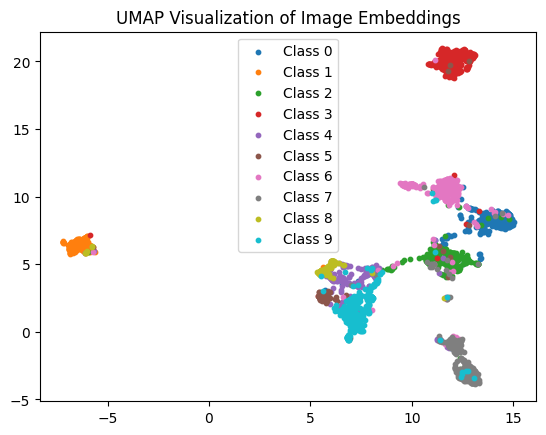

In [13]:
folder_path_img = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'
folder_path_txt = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'

subfolders = [f.name for f in os.scandir(folder_path_img) if f.is_dir()]
subfolders = ["Art & Design", "Automobiles", "Books", "Dance", "Economy", "Education", "Fashion & Style", "Food", "Global Business", "Health"]
embeddings = []
labels = []

# Assign numeric labels to each class
class_to_label = {cls: i for i, cls in enumerate(subfolders)}

for i, cls in enumerate(subfolders):
    dir_patch = os.path.join(folder_path_img, cls)
    image_paths = get_image_paths(dir_patch)
    for img_path in tqdm(image_paths):
        # Assuming get_image_embedding function returns embeddings for an image
        txt_path = os.path.join(folder_path_txt, cls, img_path.split('/')[-1].replace('.jpg', '.txt'))
        with open(txt_path, 'r') as f:
            text = f.read()
        embedding = get_combined_embedding(img_path, text, model_soft_clip, args)
        embedding = embedding.cpu().numpy()
        embeddings.append(embedding)
        labels.append(class_to_label[cls])

print("got all embeddings")
labels = np.array(labels)

# from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# db_score = davies_bouldin_score(embeddings, labels)
# ch_score = calinski_harabasz_score(embeddings, labels)
# print(f"Davies-Bouldin Score: {db_score}")
# print(f"Calinski-Harabasz Score: {ch_score}")

visualize_embeddings(embeddings, labels, method="umap")



In [171]:
# import os
# import random
# import torch
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import umap
# from torchvision import models, transforms

# # Assume 'get_image_embedding' is already defined as provided

# def get_image_paths(folder_path, extension="jpg"):
#     return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(extension)]

# def visualize_embeddings(embeddings, method="tsne", n_components=2, perplexity=30, n_neighbors=15, min_dist=0.1):
#     if method == "tsne":
#         reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
#     elif method == "umap":
#         reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
#     else:
#         raise ValueError("Method should be either 'tsne' or 'umap'")
    
#     reduced_embeddings = reducer.fit_transform(embeddings)
#     plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10, cmap='Spectral')
#     plt.title(f"{method.upper()} Visualization of Image Embeddings")
#     plt.show()

# # Replace 'your_model' with your actual model instance
# your_model =  model_multi_mixco  
# folder_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images'

# classes = ['Books', 'Dance', 'Food']
# image_paths_all = []
# dir_patches = [os.path.join(folder_path, cls) for cls in classes]

# for dir_patch in dir_patches:
#     image_paths = get_image_paths(dir_patch)
#     image_paths_all.extend(image_paths)

In [ ]:
# # Replace 'your_model' with your actual model instance
# your_model =  model_multi_mixco  
# folder_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images'

# classes = ['Books', 'Dance', 'Food']
# image_paths_all = []
# dir_patches = [os.path.join(folder_path, cls) for cls in classes]

# for dir_patch in dir_patches:
#     image_paths = get_image_paths(dir_patch)
#     image_paths_all.extend(image_paths)
    
# image_paths = get_image_paths(folder_path)
# selected_paths = random.sample(image_paths, 500)
    
# embeddings = []
# for image_path in selected_paths:
#     embedding = get_image_embedding(image_path, model, args)
#     embeddings.append(embedding.cpu().numpy())

# embeddings = np.array(embeddings)

# # TSNE Visualization
# visualize_embeddings(embeddings, method="tsne")

# # UMAP Visualization
# visualize_embeddings(embeddings, method="umap")

<class 'list'>
<class 'list'>
<class 'list'>


In [75]:
# import os
# import shutil
# import json

# def create_class_folders(data, image_folder, target_folder):
#     # Create target folder if it doesn't exist
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)

#     # Create subfolders for each class and move images
#     for item in data:
#         section = item['section']
#         image_id = item['image_id'] + ".jpg"  # Adding extension
#         class_folder = os.path.join(target_folder, section)
#         if not os.path.exists(class_folder):
#             os.makedirs(class_folder)
        
#         source_path = os.path.join(image_folder, image_id)
#         target_path = os.path.join(class_folder, image_id)

#         # Check if source image exists before copying
#         if os.path.exists(source_path):
#             shutil.copy(source_path, target_path)
#             print(f"Image {image_id} copied to {class_folder}")
#         else:
#             print(f"Image {image_id} not found in source folder: {source_path}")

# def load_json(file_path):
#     with open(file_path, 'r') as file:
#         data = json.load(file)
#     return data

# # Load data
# json_file = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/news/nytimes_test.json'
# image_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/imgs'
# target_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_test'

# data = load_json(json_file)
# print(data[0])
# # print(len(data))
# # create_class_folders(data, image_folder, target_folder)

{'section': 'Travel', 'headline': 'Afropunk, Huichica and More: 8 Music Festivals to Hit This Year', 'article_url': 'https://www.nytimes.com/2019/03/15/travel/afropunk-huichica-and-more-8-music-festivals-to-hit-this-year.html', 'article': 'An act at the FORM festival, held at Arcosanti in Arizona.\n\n\n\n\n\nAfropunk, Huichica and More: 8 Music Festivals to Hit This Year\n\nThe Woodstock Music & Arts Festival turns 50 this year and helped define music festivals for the counterculture generation. Its resulting legacy has been mixed -- from slickly produced multiday affairs to unmitigated disasters, like the Fyre Festival -- but the wildfire-spread of festivals since has led to an increasing number of exciting, smaller-scale events organized each year. These eight U.S.-based music festivals are notable for their stunning settings, extracurricular programming and highly curated, alternative lineups. Marfa Myths is a collaboration between Ballroom Marfa, a nonprofit cultural arts space, an

In [79]:
# import os
# import shutil
# import json

# def create_class_folders(data, image_folder, target_folder):
#     # Create target folder if it doesn't exist
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)

#     # Create subfolders for each class and move images
#     for item in data:
#         section = item['section']
#         text_id = item['image_id'] + '.txt'
#         text_sample = item['abstract']
#         class_folder = os.path.join(target_folder, section)
#         if not os.path.exists(class_folder):
#             os.makedirs(class_folder)

#         # put text in class_folder
#         text_file = os.path.join(class_folder, text_id)
#         with open(text_file, 'w') as f:
#             f.write(text_sample)

# def load_json(file_path):
#     with open(file_path, 'r') as file:
#         data = json.load(file)
#     return data

# # Load data
# json_file = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/news/nytimes_test.json'
# image_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/imgs'
# target_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_text_test'

# data = load_json(json_file)
# print(len(data))
# create_class_folders(data, image_folder, target_folder)

6124


In [59]:
# json_file = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/news/nytimes_train.json'
# image_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/images'
# target_folder = '/raid/nlp/rajak/Multimodal/UniS-MMC/notebooks/classified_images_train'

# data = load_json(json_file)
# data[0]

{'section': 'Theater',
 'headline': "Before 'Moonlight' and 'The Walking Dead,' a Friendship Born in the Classroom",
 'article_url': 'https://www.nytimes.com/2017/02/21/theater/danai-gurira-andre-holland-walking-dead.html',
 'article': 'Danai Gurira and Andre Holland in a theater at New York University, where they met in the Tisch Graduate Acting Program.\n\nBehind every successful person are relationships that helped forge a path. But the stories of these friendships, collaborations, alliances, romances or rivalries often are lost in the glow of achievement. In this new feature, we explore a personal connection that made a difference in the lives of two artists. Andre Holland never thought much about writing his own monologues when he attended the Tisch graduate acting program at New York University. But one day, early in his first semester in 2003, he watched another African-American student, Danai Gurira, forgo the usual speeches by white characters and perform her own material inst

In [ ]:
# label_n24news = { 'Health': 0,
#                   'Books': 1,
#                   'Science': 2,
#                   'Art & Design': 3,
#                   'Television': 4,
#                   'Style': 5,
#                   'Travel': 6,
#                   'Media': 7,
#                   'Movies': 8,
#                   'Food': 9,
#                   'Dance': 10,
#                   'Well': 11,
#                   'Real Estate': 12,
#                   'Fashion & Style': 13,
#                   'Economy': 14,
#                   'Technology': 15,
#                   'Sports': 16,
#                   'Your Money': 17,
#                   'Theater': 18,
#                   'Education': 19,
#                   'Opinion': 20,
#                   'Automobiles': 21,
#                   'Music': 22,
#                   'Global Business': 23,
#                   }

In [56]:
# import json
# import os

# def get_json_info(file_path):
#     # Check if file exists
#     if not os.path.exists(file_path):
#         print(f"File '{file_path}' does not exist.")
#         return
    
#     # Check if the file has a .json extension
#     if not file_path.endswith('.json'):
#         print(f"File '{file_path}' is not a JSON file.")
#         return

#     # Read the JSON file
#     try:
#         with open(file_path, 'r') as file:
#             data = json.load(file)
#     except json.JSONDecodeError as e:
#         print(f"Error reading JSON file: {e}")
#         return

#     # Display basic info about the JSON data
#     print(f"File: {file_path}")
#     print(f"Type of data: {type(data)}")

#     if isinstance(data, dict):
#         print(f"Number of keys: {len(data)}")
#         print(f"Keys: {list(data.keys())}")
#     elif isinstance(data, list):
#         print(f"Number of items: {len(data)}")
#         if data:
#             print(f"Type of first item: {type(data[0])}")
    
#     # Print the structure of the JSON
#     print("\nStructure of the JSON data:")
#     print_structure(data)

# def print_structure(data, indent=0):
#     prefix = ' ' * indent
#     if isinstance(data, dict):
#         for key, value in data.items():
#             print(f"{prefix}{key}: {type(value)}")
#             print_structure(value, indent + 2)
#     elif isinstance(data, list):
#         for index, item in enumerate(data[:5]):  # Limit to first 5 items for brevity
#             print(f"{prefix}[{index}]: {type(item)}")
#             print_structure(item, indent + 2)
#     else:
#         print(f"{prefix}{data}")

# # Example usage
# file_path = '/raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/news/nytimes_train.json'  # Replace with your JSON file path
# get_json_info(file_path)


File: /raid/nlp/rajak/Multimodal/UniS-MMC/datasets/n24news/news/nytimes_train.json
Type of data: <class 'list'>
Number of items: 48988
Type of first item: <class 'dict'>

Structure of the JSON data:
[0]: <class 'dict'>
  section: <class 'str'>
    Theater
  headline: <class 'str'>
    Before 'Moonlight' and 'The Walking Dead,' a Friendship Born in the Classroom
  article_url: <class 'str'>
    https://www.nytimes.com/2017/02/21/theater/danai-gurira-andre-holland-walking-dead.html
  article: <class 'str'>
    Danai Gurira and Andre Holland in a theater at New York University, where they met in the Tisch Graduate Acting Program.

Behind every successful person are relationships that helped forge a path. But the stories of these friendships, collaborations, alliances, romances or rivalries often are lost in the glow of achievement. In this new feature, we explore a personal connection that made a difference in the lives of two artists. Andre Holland never thought much about writing his ow